## Exploring Malaria Simulation Output Data

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

strategies = ['status_quo',
              'AL5',
              'AL4',
              'ASAQ',
              'ASAQ25-DHA-PPQ75',
              'AL75-ASAQ25',
              'AL25-DHA-PPQ75',
              'AL25-ASAQ75',
              'ASAQ50-DHA-PPQ50',
              'AL50-DHA-PPQ50',
              'DHA-PPQ',
              'AL75-DHA-PPQ25']

table_names = ['monthlydata', 'sqlite_sequence', 'monthlysitedata', 'genotype', 'monthlygenomedata']
 
def get_all_tables(db: str) -> list:
    """
    Get all tables in a sqlite3 database

    Args:
    db (str): path to sqlite3 database

    Returns:
    list: list of tables in the database
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        c = conn.cursor()
        c.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = c.fetchall()
    
    return [table[0] for table in tables]

def get_table(db: str, table: str) -> pd.DataFrame:
    """
    Get a table from a sqlite3 database

    Args:
    db (str): path to sqlite3 database
    table (str): name of table to get

    Returns:
    pd.DataFrame: table as a pandas DataFrame
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    return df

def calculate_treatment_failure_rate(data: pd.DataFrame, locationid: int = 0) -> pd.DataFrame:
    """
    Calculate treatment failures for a given table

    Args:
    data (DataFrame): monthlysitedata table to calculate treatment failures
    locationid (int): locationid to filter by

    Returns:
    pd.DataFrame: table with treatment failures
    """
    # Calculate treatment failures
    if locationid > 0:
        data = data[data["locationid"] == locationid]
    data['failure_rate'] = data['treatmentfailures'] / data['treatments']

    return data

def aggregate_monthlysitedata(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
    """
    Aggregate data by strategy. This function searchs path for all the result files for the given strategy and aggregates them.

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for

    Returns:
    pd.DataFrame: aggregated data
    pd.Series: monthlydataid column
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"*_{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy}")
        return
    # Get the monthlysitedata table for the first file to set up aggregated data
    monthlysitedata_columns = get_table(files[0], 'monthlysitedata').columns.to_list()
    monthlysitedata_columns.remove('monthlydataid')
    monthlysitedata_columns.append('failure_rate')
    monthlysitedata = {column : pd.DataFrame() for column in monthlysitedata_columns}    
    # Aggregate data for the rest of the files
    for file in files:
        # print(f"Aggregating data for {file}")
        data = get_table(file, 'monthlysitedata')
        if locationid > 0:
            data = data[data["locationid"] == locationid]
        if 'failure_rate' not in data.columns:
            data = calculate_treatment_failure_rate(data)
        monthlydataid = data['monthlydataid']
        for column in monthlysitedata_columns:            
            if column != 'monthlydataid':                
                monthlysitedata[column] = pd.concat([monthlysitedata[column], data[column]], axis=1)
    # Calculate statistics for the aggregated data
    for column in monthlysitedata_columns:
        if column != 'monthlydataid':
            monthlysitedata[column]['mean'] = monthlysitedata[column].mean(axis=1)
            monthlysitedata[column]['median'] = monthlysitedata[column].median(axis=1)
            monthlysitedata[column]['95th'] = monthlysitedata[column].quantile(axis=1, q=0.95)
            monthlysitedata[column]['5th'] = monthlysitedata[column].quantile(axis=1, q=0.05)           
            
    return monthlysitedata, monthlydataid

def save_aggregated_data(monthlysitedata: dict[str, pd.DataFrame], monthlydataid: pd.Series, strategy: str, path: str):
    """
    Save aggregated data to a file

    Args:
    monthlysitedata (dict[str, pd.DataFrame]): aggregated data
    monthlydataid (pd.Series): monthlydataid column
    strategy (str): strategy
    path (str): path to save the file
    """
    with sqlite3.connect(os.path.join(path, f"{strategy}_aggregated.db")) as conn:
        for column in monthlysitedata.keys():
            monthlysitedata[column].to_sql(column, conn, index=False)
        monthlydataid.to_sql('monthlydataid', conn, index=False)

def plot_strategy_treatment_failure(data: pd.DataFrame, months: pd.DataFrame, strategy: str, figsize: tuple = (18, 3)):
    """
    Plot treatment failure rate for a given strategy

    Args:
        data (pd.DataFrame): treatement failure data to plot
        months (pd.DataFrame): months for the data
        strategy (str): strategy to plot
        figsize (tuple): figure size
    
    Returns:    
        tuple: figure and axis
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(months / 12, data['failure_rate']['mean'], label='Mean')
    ax.fill_between(months / 12, data['failure_rate']['5th'], data['failure_rate']['95th'], color='b', alpha=0.15, label='5th-95th percentile')
    ax.axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
    ax.set_title(f"{strategy} Treatment Failure Rate")
    ax.set_xlabel("Years")
    ax.set_ylabel("Treatment Failure Rate")
    ax.legend()
    return fig, ax

In [4]:
DATA_SOURCE: str = os.path.join("G:\\", "My Drive", "Desktop", "output_old")

In [6]:
data, months = aggregate_monthlysitedata(DATA_SOURCE, "status_quo", 1)

In [9]:
data['treatmentfailures']

,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,mean,median,95th,5th
0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
30,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
60,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
90,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
120,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,674,801,666,574,545,514,503,533,546,484,551,581.000000,548.500000,724.8,496.35
11430,483,492,427,388,362,357,393,386,344,332,384,395.272727,387.000000,486.6,339.80
11460,378,439,388,380,310,283,326,322,276,277,302,334.636364,324.000000,408.4,276.65
11490,417,406,370,376,293,301,279,335,317,272,308,334.000000,325.500000,410.4,276.55


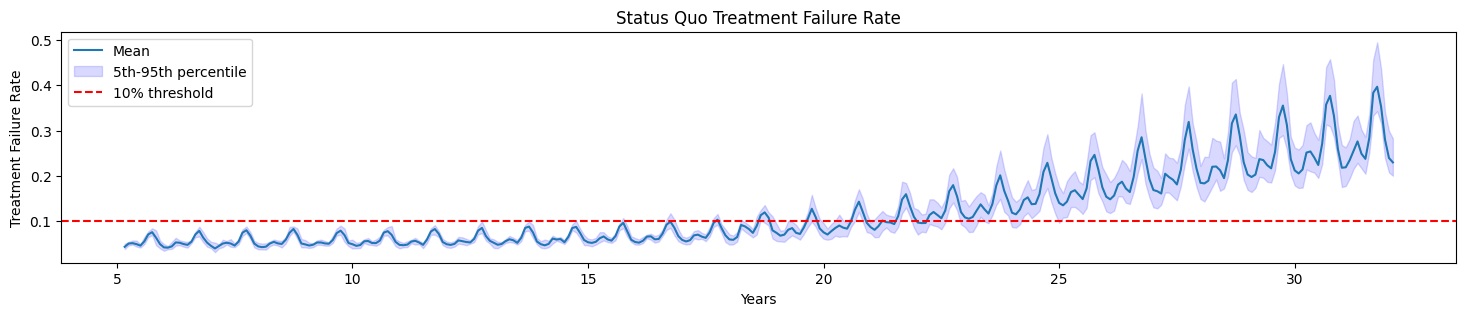

In [10]:
fig, ax = plot_strategy_treatment_failure(data, months, "Status Quo")
plt.show()

In [29]:
def aggregate_treatment_failures_for_strategies(path: str, strategies: list[str], locationid: int = 0) -> dict[str, pd.DataFrame]:
    """
    Aggregate treatment failures for all strategies

    Args:
    path (str): path to search for result files
    strategies (list): list of strategies to aggregate data for

    Returns:
    dict: dictionary of aggregated dataframes
    """
    aggregated_data = {}
    for strategy in strategies:
        print(f"Aggregating data for {strategy}")
        try:
            data, months = aggregate_monthlysitedata(path, strategy, locationid)
        except TypeError as e:
            print(e)
            continue
        except FileNotFoundError as e:
            print(e)
            continue
        
        try:
            months = months.to_numpy()
            aggregated_strategy_data = pd.DataFrame.from_dict({
                'months': months,
                'mean': data['failure_rate']['mean'],
                'median': data['failure_rate']['median'],
                '5th': data['failure_rate']['5th'],
                '95th': data['failure_rate']['95th']
            })
        except KeyError as e:
            print(e)
            continue
        except ValueError as e:
            print(e)
            continue
        aggregated_strategy_data.index = aggregated_strategy_data['months']
        aggregated_data[strategy] = aggregated_strategy_data
    return aggregated_data

In [30]:
aggregated = aggregate_treatment_failures_for_strategies(DATA_SOURCE, strategies, 1)

Aggregating data for status_quo
Aggregating data for AL5
Aggregating data for AL4
No files found for strategy AL4
cannot unpack non-iterable NoneType object
Aggregating data for ASAQ
Aggregating data for ASAQ25-DHA-PPQ75
Aggregating data for AL75-ASAQ25
Aggregating data for AL25-DHA-PPQ75
Aggregating data for AL25-ASAQ75
Aggregating data for ASAQ50-DHA-PPQ50
Aggregating data for AL50-DHA-PPQ50
Aggregating data for DHA-PPQ
array length 113 does not match index length 114
Aggregating data for AL75-DHA-PPQ25


In [ ]:
def plot_strategy_results(path: str, strategy: str, locationid:int = 0) -> plt.Figure:
    """
    Plots the treatment failure rate for a given strategy. If locationid is provided, only that location is plotted.
    If more than one results file is found in the path, the data is aggregated.

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    locationid (int): locationid to filter by

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"*_{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    # Read all results files
    failures = pd.DataFrame()
    for file in results_files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data, locationid)
        failures[file] = data['failure_rate']
        
    if locationid > 0:
        failures = failures.loc[failures['locationid'] == locationid]
    # else, aggregate all locations by taking the mean of the failure rates at each month
    else:
        months = failures['monthlydataid'].unique()
        monthly_average = pd.DataFrame()
        for month in months:
            monthly_data = failures.loc[failures['monthlydataid'] == month]
            monthly_average[month, 'population'] = monthly_data['population'].sum()
            monthly_average[month, 'treatments'] = monthly_data['treatments'].sum()
            monthly_average[month, 'treatmentfailures'] = monthly_data['treatmentfailures'].sum()
            monthly_average[month, 'failure_rate'] = monthly_data['failure_rate'].mean()


    failures['mean'] = failures.mean(axis=1)


    fig, ax = plt.subplots()
    ax.plot(failures['monthlydataid'])

['output/rwanda_AL5_4_monthly_data_0.db', 'output/rwanda_AL5_7_monthly_data_0.db', 'output/rwanda_AL5_0_monthly_data_0.db', 'output/rwanda_AL5_8_monthly_data_0.db', 'output/rwanda_AL5_3_monthly_data_0.db', 'output/rwanda_AL5_1_monthly_data_0.db', 'output/rwanda_AL50-DHA-PPQ50_0_monthly_data_0.db', 'output/rwanda_AL5_6_monthly_data_0.db', 'output/rwanda_AL5_5_monthly_data_0.db', 'output/rwanda_AL5_2_monthly_data_0.db', 'output/rwanda_AL5_9_monthly_data_0.db', 'output/rwanda_AL50-DHA-PPQ50_1_monthly_data_0.db', 'output/rwanda_AL5_10_monthly_data_0.db']
